In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
1000/46754783

2.1388186102799366e-05

To do:
1. Compare results for Markov chains (**done**, same results cause of $\hat{R} < 1.1$):
    1. median and std of all chains'values (**done**)
    2. mean of all chains of the mean value (**done**)
2. In analysis.py generalize of prior's distribution parameters (**no need**)
3. modulation of active cases of 7 days (monday), try to fit weekly mean data, change beta accordingly
4. Presentation title: something like "Limits of forecasting COVID-19 data"
5. Change the burn in size, so traces plot showing the burn in one and so I have to raise the number of iterations
<br> Optional:
    1. Add forecasting for t_peak
    2. Add forecasting for end of end of epidemic (confirmed cases less then 1000 for the first time)

In [1]:
import sys
import pandas as pd 
import numpy as np
import pyjags as pj
import arviz as az
from scipy import stats
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from datetime import datetime
import seaborn as sns
from analysis import Analysis

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image 


%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

#  Analytical solution of the SCIR model at low fraction of infected individuals

The SCIR model includes the usual states of an SIR model plus a new class C for individuals
sent to confinement that are susceptible but not infected.

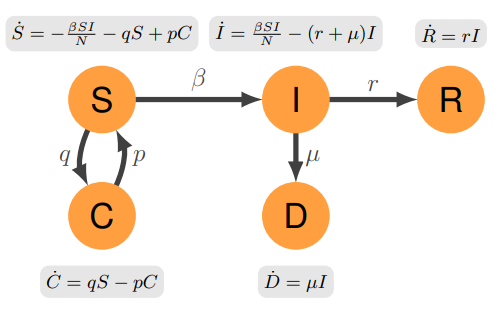

In [3]:
Image("SCIR_model.png")

Diagram of the epidemic model along with the equations ruling the dynamics. Susceptible individuals $(S)$ can enter and exit confinement $(C)$, or become infected $(I)$. Infected
individuals can recover $(R)$ or die $(D)$. $N$ is the total population. Rates for each process are
displayed in the figure, $q$ depends on specific measures restricting mobility, while $p$ stands for
individuals that leave the confinement measures (e.g. people working at essential jobs like food
supply, health care, policing) as well as for defection. We fit I to data on officially diagnosed
cases, which are automatically quarantined: the underlying assumption is that the real, mostly
undetected, number of infections is proportional to the diagnosed cases.
<br>

In a sufficiently large population, the number of infected individuals at the initial stages of the infection is well below the population size. Under certain conditions, it may stay small in
comparison to the number of susceptible individuals remaining. This seems to be the case for
several weeks of spread of COVID-19 in most countries.
If $I(t)/N \ll 1$, then the nonlinear term in the equation for the number of susceptible
individuals can be neglected. Within this approximation, the equations determining the dynamics are


$$\left\{\begin{array}
\dot \dot{S} = -qS + pC, \\
\dot{C} = qS - pC, \\
\dot{I} = \frac{\beta}{N}SI - (r+\mu)I, \\
\dot{R} = rI, \\
\dot{D} = \mu I.  \\
\end{array}\right.$$


The first two equations imply $S + C = N$, so $C = N − S$ and reformulate the equations as

$$\left\{\begin{matrix}
\dot{S} = -(q+p)S + pN, \\
\dot{I} = \frac{\beta}{N}IS - (r+\mu)I, \\
\end{matrix}\right.$$

The solution of this system can be obtained in closed form as

\begin{array}[]
SS(t) = \frac{N}{q+p}[p+qe^{-(p+q)t}], & R(t)=r\int_{0}^{t}I(u)du,\\
I(t)=I_{0}e^{[R^*_0(t)-1](r+\mu)t}, & D(t)=\mu\int_{0}^{t}I(u)du,\\
\end{array}

where
\begin{array}[]
RR^*_0(t) = \frac{R_0}{q+p}[p+q\frac{1-e^{-(p+q)t}}{(q+p)t}], & R_0=\frac{\beta}{r+\mu}\\
\end{array}

is the $\textit{effective basic reproduction number}$ modulated by the confinement, $R_0$ being its value at the beginning of the
epidemic.

## Fit a parametric Bayesian model


Simultaneously fit the number of active cases (I) and the
new number of cases in the interval ∆t = 1 day of recovered (R) and dead (D) cases in logarithmic scale—a linear scale
would give a biased larger weight to later times.
<br>

Variables:

\begin{array}[lll]
 llogI(t) \sim N(logI(t_0) + [\beta − (r + \mu)](t − t_0), \sigma_I),& t_0 < t ≤ t_q, & \mbox{(before confinement measure)}\\ 
 logI(t) \sim N(logI(t_q) + [R^*_0(t − t_q)−1](r + \mu)(t − t_q), \sigma_I),& t_q < t, & \mbox{(after confinement measure)}\\ 
 logX(t) \sim N(log(r + \mu) + logI(t), \sigma_X),& t > t_{X_{0}} &
\end{array}

where $X(t)$ = $\Delta$ $R(t)$ + $\Delta$ $D(t)$ is the change in the number of recovered plus dead cases daily reported.
Priors

\begin{array}
\beta\beta ∼ U(0,1), & 1/\sigma^2_I ∼ \Gamma(0.01,0.01), \\
r + \mu ∼ U(0,1), & 1/σ^2_X ∼ \Gamma(0.01,0.01), \\ 
p ∼ U(0,5), \\
q ∼ U(0,5)
\end{array}

where ∼ stands for distributed as, and $N$, $U$ and $Γ$ stand for Normal, Uniform and Gamma distributions. $t_0$ and $t_{X_{0}}$ stand for the days (since February 28th) where the first Infected and Recovered+Death cases were reported, respectively.
<br>
<br>
This model fit directly the solution of the deterministic model.
<br>
The priors for $\beta$ and $r + \mu$ are informative priors derived from the fact that in every country where cases of
coronavirus are detected, the doubling period at the very early stages of the epidemic was never smaller than two days.
Hence we have taken for these parameters a prior U(0,1) ($\beta < 1$). For the other parameters we assume a non-informative prior
U(0,5) (changes faster than 1/5 day are meaningless in any compartmental model).

## Dataset Spain
After the 18th of May the Spanish government stopped publishing data about recovered

In [15]:
# data until 17 may
url = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/covid-19-es.csv"
# data until 31 march
url_confirmed = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/confirmed-march31.csv"
url_recovered = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/recovered-march31.csv"
url_death = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/deaths-march31.csv"

df = pd.read_csv(url, keep_date_col=True)
df = df[~df.isna().any(axis=1)].reset_index(drop=True)
df['Day'] = pd.date_range(start="2020.01.31", end="2020.05.17")
df['Day'] = pd.to_datetime(df.Day, format='%Y-%m-%d').dt.strftime('%Y.%m.%d')

df.loc[(df.Day <= "2020.03.31") & (df.Day >= "2020.02.27"), ['Death', 'Confirmed', 'Recovered']] = np.column_stack([pd.read_csv(url_death)['Spain'],
                                                                        pd.read_csv(url_confirmed)['Spain'],
                                                                        pd.read_csv(url_recovered)['Spain']])
df['Confirmed'] = df.Confirmed - df.Recovered - df.Death
df['Confirmed_smooth'] = df.Confirmed.rolling(2, min_periods=1).mean()
df['Recovered_Death'] = (df.Recovered + df.Death).diff().fillna(0) # (daily derivative)
df['Recovered_Death_smooth'] = df.Recovered_Death.rolling(2, min_periods=1).mean()

df

,Day,Death,Confirmed,Recovered,Confirmed_smooth,Recovered_Death,Recovered_Death_smooth
0,2020.01.31,0.0,1.0,0.0,1.0,0.0,0.0
1,2020.02.01,0.0,1.0,0.0,1.0,0.0,0.0
2,2020.02.02,0.0,1.0,0.0,1.0,0.0,0.0
3,2020.02.03,0.0,1.0,0.0,1.0,0.0,0.0
4,2020.02.04,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
103,2020.05.13,27091.0,60777.0,140823.0,61570.0,2025.0,2019.0
104,2020.05.14,27308.0,58858.0,143374.0,59817.5,2768.0,2396.5
105,2020.05.15,27449.0,57951.0,144783.0,58404.5,1550.0,2159.0
106,2020.05.16,27549.0,56703.0,146446.0,57327.0,1763.0,1656.5


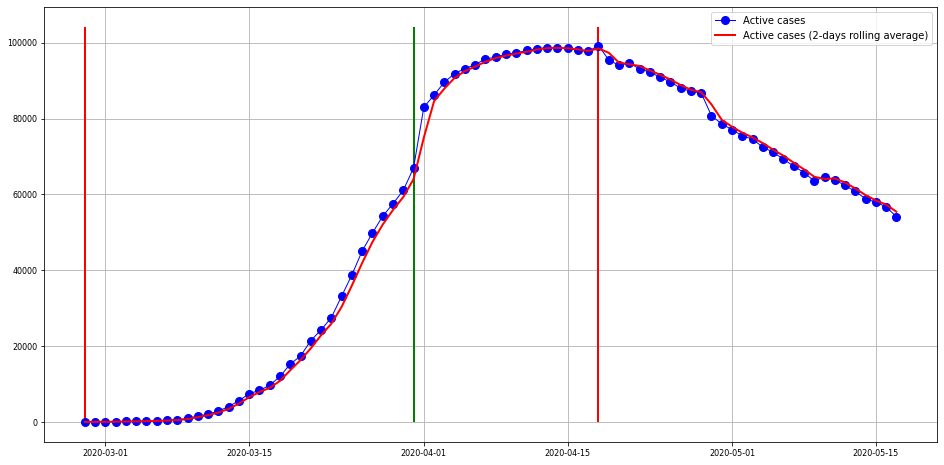

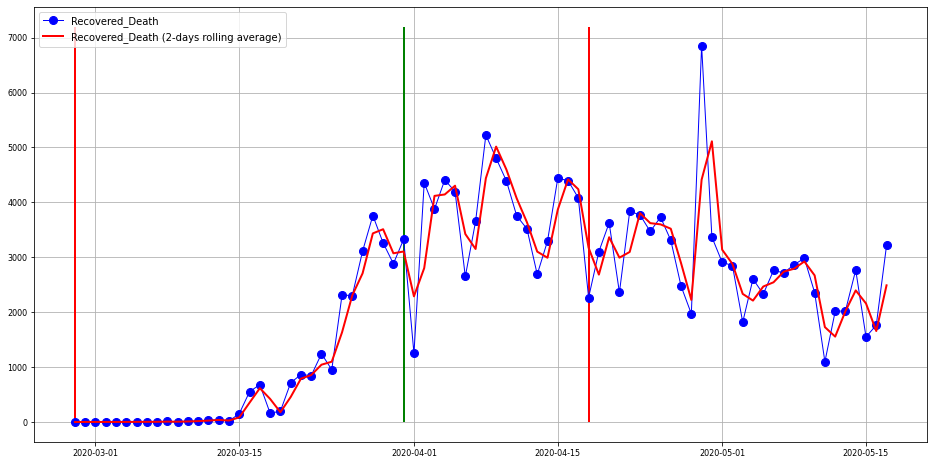

In [103]:
# save fgure with plot from gennuary
plt.plot(pd.to_datetime(df.Day), df.Confirmed, 'bo-', lw=1, label='Active cases')
plt.plot(pd.to_datetime(df.Day), df.Confirmed_smooth, 'r', lw=2, label='Active cases (2-days rolling average)')
ymin, ymax = plt.ylim()
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.02.28']), 0, ymax, color='r')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.03.31']), 0, ymax, color='g')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.04.18']), 0, ymax, color='r')
plt.legend()
plt.grid()
plt.show()

plt.plot(pd.to_datetime(df.Day), df.Recovered_Death, 'bo-', lw=1, label='Recovered_Death')
plt.plot(pd.to_datetime(df.Day), df.Recovered_Death_smooth, 'r', lw=2, label='Recovered_Death (2-days rolling average)')
ymin, ymax = plt.ylim()
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.02.28']), 0, ymax, color='r')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.03.31']), 0, ymax, color='g')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.04.18']), 0, ymax, color='r')
plt.legend()
plt.grid()

In [65]:
df = df[df.Day >= '2020.02.27'].reset_index(drop=True)
df

,Day,Death,Confirmed,Recovered,Confirmed_smooth,Recovered_Death,Recovered_Death_smooth
0,2020.02.28,0.0,32.0,0.0,24.0,0.0,-1.5
1,2020.02.29,0.0,44.0,0.0,38.0,0.0,0.0
2,2020.03.01,0.0,66.0,0.0,55.0,0.0,0.0
3,2020.03.02,0.0,114.0,0.0,90.0,0.0,0.0
4,2020.03.03,0.0,150.0,0.0,132.0,0.0,0.0
...,...,...,...,...,...,...,...
75,2020.05.13,27091.0,60777.0,140823.0,61570.0,2025.0,2019.0
76,2020.05.14,27308.0,58858.0,143374.0,59817.5,2768.0,2396.5
77,2020.05.15,27449.0,57951.0,144783.0,58404.5,1550.0,2159.0
78,2020.05.16,27549.0,56703.0,146446.0,57327.0,1763.0,1656.5


# Fit ending before peak data for the daily number of active cases
fit from 2020-02-27 to 2020-03-29 with confinement measure aplied on 2020-03-11

In [66]:
# instantiating an analysis object
days = df['Day'].values
confirmed = df['Confirmed'].values
recovered_death = df['Recovered_Death'].values
tq = '2020.03.09' # in the article is 11/03 but in the repository is 09/03
tmax = '2020.03.31'
tf = '2020.05.17'
country = 'Spain'

analysis_esp = Analysis(days, confirmed, recovered_death, tq, tmax, tf, country)

In [69]:
%%time
# call sampler analysis' method
analysis_esp.sampler(nchains=12, nthreads=12, niter=10000, burn_in=0.5)

sampling: iterations 120000 of 120000, elapsed 0:00:02, remaining 0:00:00
CPU times: user 21.4 s, sys: 1.5 s, total: 22.9 s
Wall time: 3.17 s


In [70]:
analysis_esp.summary()

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.3730,0.0079,0.3586,0.3893,1.0018
rmu,0.0220,0.0052,0.0142,0.0346,1.0014
q,0.0557,0.0039,0.0495,0.0651,1.0032
p,0.0043,0.0061,0.0002,0.0224,1.0011
tauI,57.6586,15.9021,32.3548,94.5402,1.0004
tauX,0.7921,0.2264,0.4303,1.3081,1.0001


Where

$$\hat{R} = \sqrt{\frac{\hat{V}}{W}}$$ is the **potential scale reduction factor**
<br>
<br>
- &emsp; **W** is the within-chain variance (mean of variance of each chain),
<br>
- &emsp; $\hat{V}$ is the variance between multiple chains.
<br>
<br>
This is the potential scale reduction factor, which converges to unity when each of the traces is a sample from the target posterior.
<br>
Values greater than one indicate that one or more chains have not yet converged.
<br> The simulation was runned until the $\hat{R}$ of each parameter was < 1.1.

In [21]:
# Compute the median and std of sigmaI and sigmaX

tauI = analysis_esp.samples['tauI'].ravel()
std_I = np.power(tauI, -1/2)
sd_std_I = np.std(std_I)
std_I = np.median(std_I)

tauX = analysis_esp.samples['tauX'].ravel()
std_X = np.power(tauX, -1/2)
sd_std_X = np.std(std_X)
std_X = np.median(std_X)




std_I, sd_std_I, std_X, sd_std_X

(0.2110392841951222,
 0.03005851354992083,
 0.9325230707242436,
 0.14435368234870033)

In [8]:
def autocorrelation_time(self, varname, nlags=1000):
    def fit_time(x, tau):
        return np.exp(-x/tau)
    
    times = np.zeros((self.nchains, len(varname)))
    x = np.arange(nlags+1)
    for i in range(6):
        for j in range(12):
            y = acf(self.samples[varname[i]][0, :, j], fft=True, nlags=nlags)
            popt, pcov = curve_fit(fit_time, x, y)
            times[j,i] = popt
    return times


def autocorrelation_time_plot(times, names):
    fig, ax = plt.subplots(len(names), figsize=(10, 10), constrained_layout=True)
    for i in range(len(names)):
        ax[i].plot(times[:,i], '-ob')
        ax[i].set_title(f'Autocorrelation time for {names[i]}', weight='bold')
        ax[i].grid()

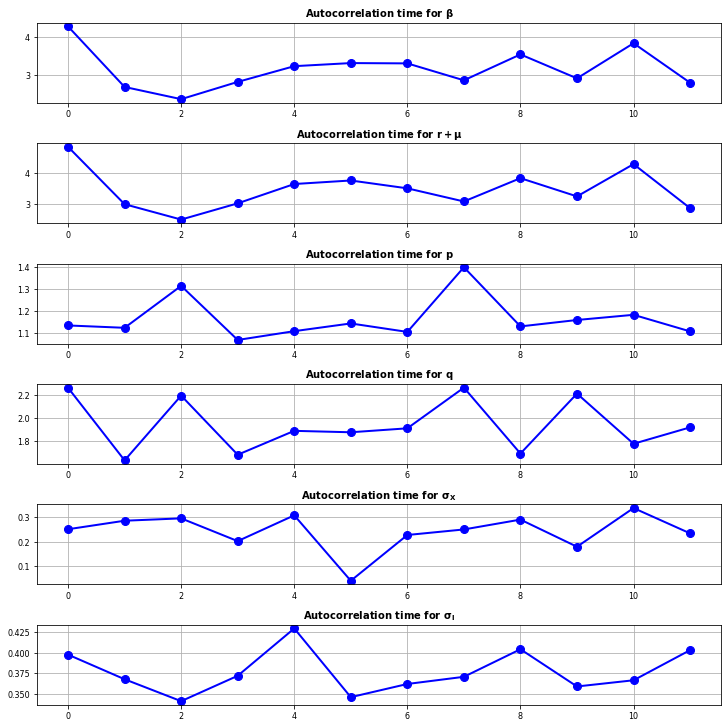

In [9]:
varname = np.array(['beta', 'rmu', 'p', 'q', 'tauX', 'tauI'])
names = np.array([r'$ \mathbf{\beta} $', r'$ \mathbf{r + \mu} $',
                       '$ \mathbf{p} $', '$ \mathbf{q} $', r'$ \mathbf{\sigma_{X}} $',
                       r'$ \mathbf{\sigma_{I}} $'])

times = autocorrelation_time(analysis_esp, varname)

autocorrelation_time_plot(times, names)

In [10]:
times.max()*50, times.max()*1000, times.min()

(242.95013190563265, 4859.002638112653, 0.041764290502603246)

In [349]:
analysis_ita_3.date[analysis_ita_3.date == '2020.11.27'].index[0]

46

0.02110376991838321


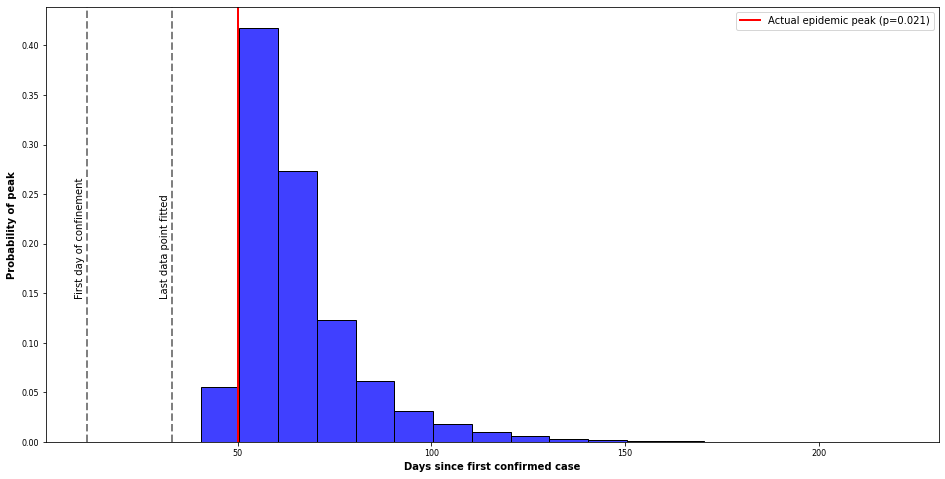

In [344]:
def peak_posterior(self, second_wave=False):
    beta = self.samples['beta'].ravel()
    rmu = self.samples['rmu'].ravel()
    p = self.samples['p'].ravel()
    q = self.samples['q'].ravel()
    tf = self.data['tf'] - 1
    I = self.data['I']


    traces = pd.DataFrame((beta, rmu, p, q), index=['beta', 'rmu', 'p', 'q']).T
    tmp = traces[traces.rmu * (traces.p + traces.q) > traces.beta * traces.p]
    
    string = 'First day of confinement'
    # percentual of cases actually peak
    if (self.country == 'Italy') & (not(second_wave)):
        tmax = self.date[analysis_ita.date == '2020.04.19'].index[0]
        string = 'DPCM lockdown'
    elif (self.country == 'Italy') & second_wave:
        tmax = self.date[self.date == '2020.11.27'].index[0]
        string = 'DPCM red zones'
    else:    
        tmax = self.data['I'].argmax()
        
    t_peak = 1 / (tmp.p + tmp.q) * np.log(tmp.beta * tmp.q / (tmp.rmu * (tmp.p + tmp.q) - tmp.beta * tmp.p))
    
    p_tmax = len(t_peak[np.round(t_peak) == tmax]) / len(t_peak)
    print(p_tmax )

    sns.histplot(t_peak, binwidth=10, stat='probability', color='b')
    ax = plt.gca()
    ax.axvline(tmax, color='r', linestyle='-', label=f'Actual epidemic peak (p={p_tmax:.3f})')
    ax.axvline(self.data['tq'], color='gray', linestyle='--')
    ax.axvline(self.data['tmax'], color='gray', linestyle='--')

    y_lim = ax.get_ylim()[1] / 3
    ax.text(self.data['tq']-3, y_lim, string, rotation=90)
    ax.text(self.data['tmax']-3, y_lim, 'Last data point fitted', rotation=90)

    ax.set_xlabel('Days since first confirmed case')
    ax.set_ylabel('Probability of peak')
    plt.legend()
    plt.show()
    return t_peak
    
t_peak = peak_posterior(analysis_esp)

# Kolmogorov smirnov test for goodness of fit

Ks_2sampResult(statistic=0.40625, pvalue=0.009516275438959759)
0.9975196071526129


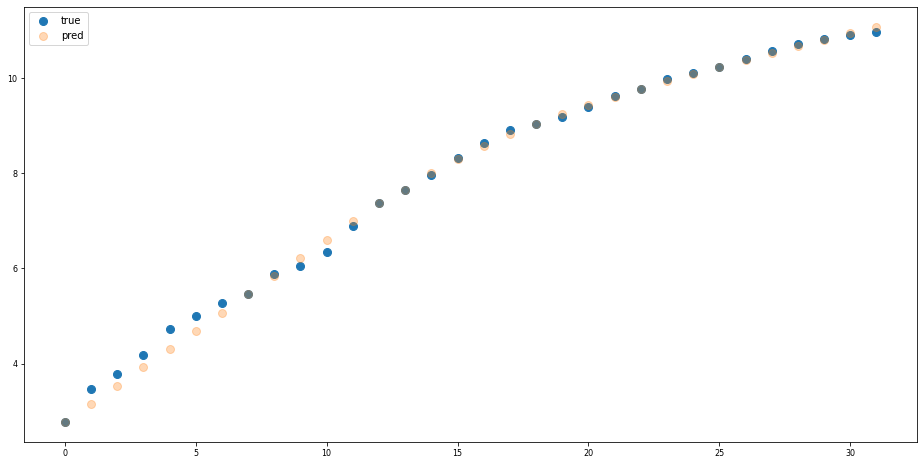

In [29]:
I = analysis_esp.data()['I']
t0 = analysis_esp.data()['t0'] - 1
tmax = analysis_esp.data()['tmax']
I_exact = analysis_esp.infected_exact()

y_true = I[t0:tmax]
y_pred = I_exact[t0:tmax]

from scipy import stats
from scipy.stats import ks_2samp

test = ks_2samp(y_true+2, y_pred)
print(test)
print((stats.linregress(y_true, y_pred)[2]) ** 2)


plt.scatter(np.arange(len(y_true)), y_true, label='true')
plt.scatter(np.arange(len(y_pred)), y_pred, label='pred', alpha=0.3)
plt.legend()


### Trace, posterior distribution, autocorrelation plot before peak (Spain)

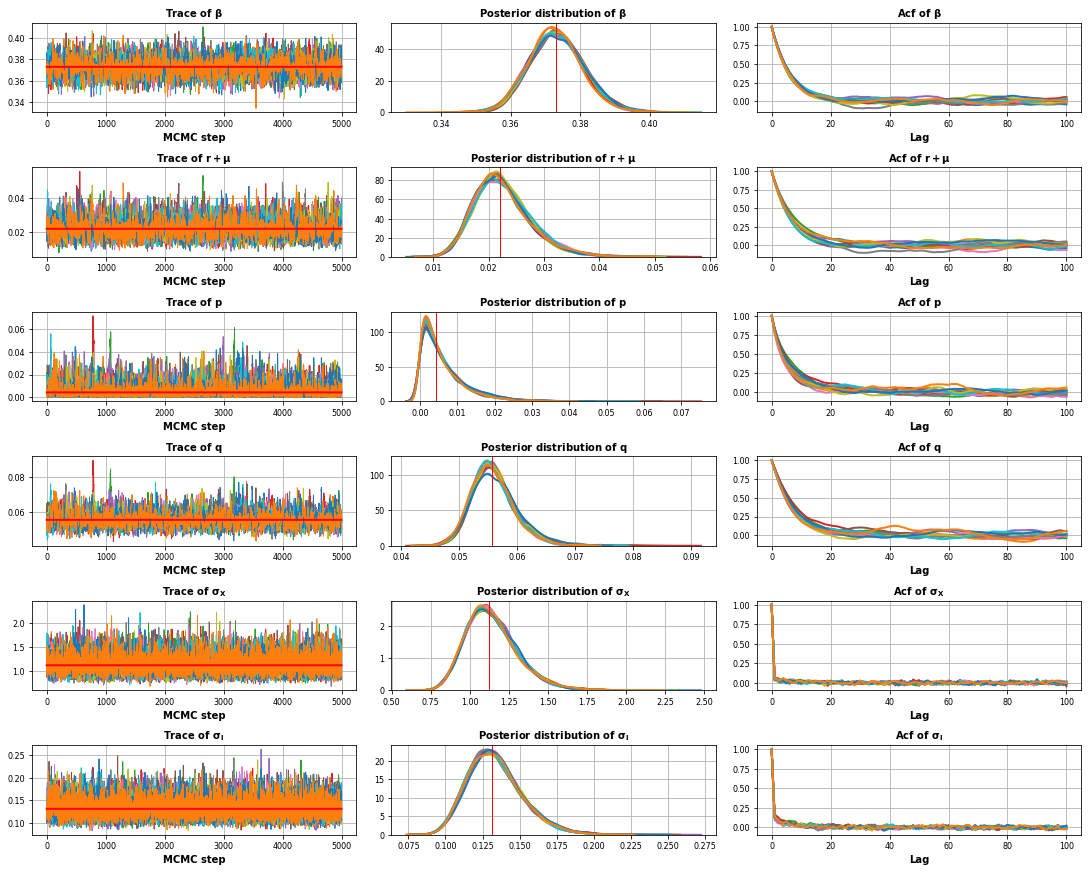

In [71]:
samples = analysis_esp.samples
varname = np.array(['beta', 'rmu', 'p', 'q', 'tauX', 'tauI'])
names = np.array([r'$ \mathbf{\beta} $', r'$ \mathbf{r + \mu} $',
                       '$ \mathbf{p} $', '$ \mathbf{q} $', r'$ \mathbf{\sigma_{X}} $',
                       r'$ \mathbf{\sigma_{I}} $'])

fig, ax = plt.subplots(6, 3, figsize=(15, 12), constrained_layout=True)

for i in range(6):
    exp = 1
    if (varname[i] == 'tauI') | (varname[i] == 'tauX'):
        exp = -1/2
    for j in range(12):
        ax[i, 0].plot(np.power(samples[varname[i]][0, :, j], exp), label=f'Chain {j+1}', lw=1)
        sns.distplot(np.power(samples[varname[i]][0, :, j], exp), hist=False, kde=True, ax=ax[i,1])
        ax[i,2].plot(acf(np.power(samples[varname[i]][0, :, j], exp), fft=True, nlags=100))
    ax[i, 0].plot(np.arange(5000), [np.median(np.power(samples[varname[i]].ravel(), exp))] * 5000, c='r', lw=2, label='Median')
    ax[i, 0].set_xlabel('MCMC step')
    ax[i, 0].set_title(f'Trace of {names[i]}', weight='bold')
    #ax.legend()#bbox_to_anchor=(1.001, 1.01), loc='upper left')
    ax[i, 0].grid()
    ax[i, 1].axvline(np.median(np.power(samples[varname[i]].ravel(), exp)), color='r', lw=1, label='Actual epidemic peak')
    ax[i, 1].set_ylabel('')
    ax[i, 1].set_title(f'Posterior distribution of {names[i]}', weight='bold')
    ax[i, 1].grid()
    ax[i,2].set_xlabel('Lag')
    ax[i,2].set_title(f'Acf of {names[i]}', weight='bold')
    ax[i, 2].grid()

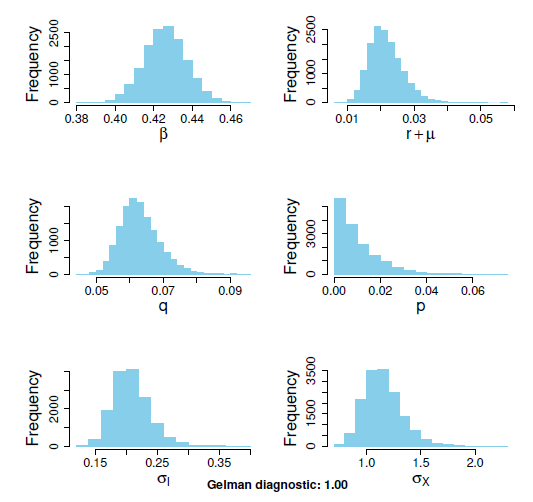

In [112]:
Image("../Immagini/Posterior Distribution paper.png")

In [32]:
t_esp, *SCIX_esp = analysis_esp.simulation()

### Plotting fit results before peak

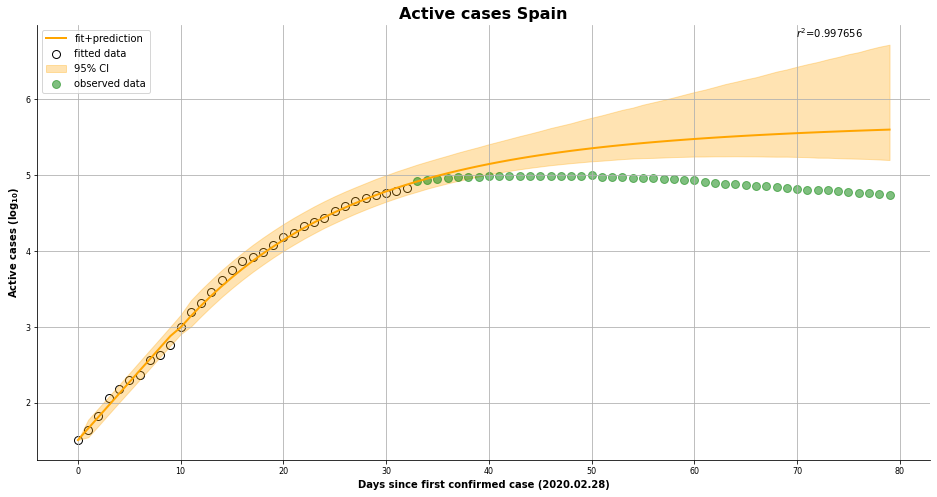

In [72]:
analysis_esp.plot_results(CI=95, Y=True, observed=True)
#plt.plot(t_esp, np.log(SCIX_esp[2])/np.log(10), 'b', alpha=0.5, lw=2, label='simulated')
#plt.savefig("active_cases_Spain.png", quality=100, transparent=True, dpi=400)

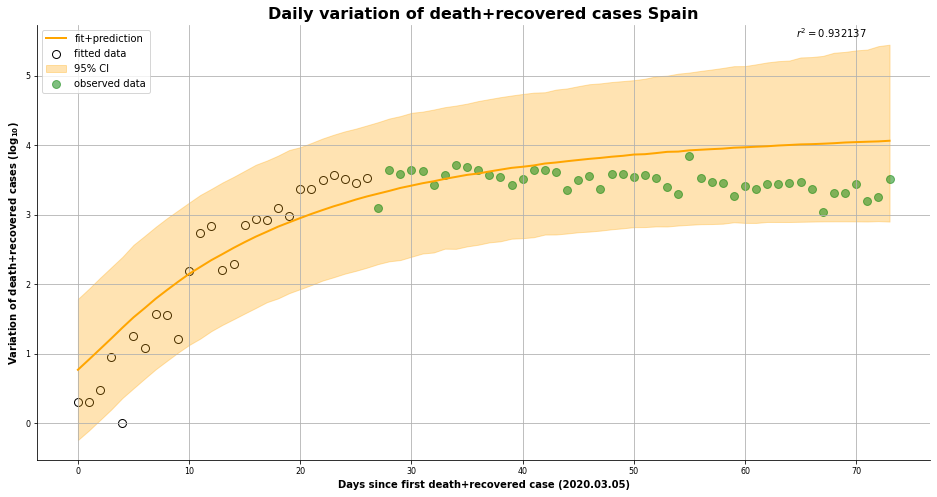

In [73]:
analysis_esp.plot_results(Z=True, observed=True)
#plt.plot(t_esp[:], np.log(SCIX_esp[3])/np.log(10), 'b', alpha=0.5, lw=2, label='simulated')
#plt.savefig("death_recovered_Spain.png", quality=100, transparent=True, dpi=400)

# Fit ending after peak data for the daily number of active cases

In [75]:
df = pd.read_csv(url, keep_date_col=True)
df = df[~df.isna().any(axis=1)].reset_index(drop=True)
df['Day'] = pd.date_range(start="2020.01.31", end="2020.05.17")
df['Day'] = pd.to_datetime(df.Day, format='%Y-%m-%d').dt.strftime('%Y.%m.%d')

df = df[df.Day >= '2020.02.27'].reset_index(drop=True)
df

,Day,Death,Confirmed,Recovered
0,2020.02.27,1.0,17.0,2.0
1,2020.02.28,1.0,35.0,2.0
2,2020.02.29,1.0,54.0,2.0
3,2020.03.01,1.0,82.0,2.0
4,2020.03.02,1.0,136.0,3.0
...,...,...,...,...
76,2020.05.13,27091.0,228691.0,140823.0
77,2020.05.14,27308.0,229540.0,143374.0
78,2020.05.15,27449.0,230183.0,144783.0
79,2020.05.16,27549.0,230698.0,146446.0


In [196]:
analysis_esp_2 = Analysis(df['Day'].values, df['Confirmed'].values, df['Recovered_Death'].values, 
                        '2020.03.09', '2020.04.18', '2021.03.01', 'Spain') # 2020.05.17

In [197]:
%%time
# call sampler analysis' method
analysis_esp_2.sampler(nchains=12, nthreads=12, niter=50000, burn_in=0.5)

sampling: iterations 33127 of 600000, elapsed 0:00:05, remaining 0:01:31
sampling: iterations 108035 of 600000, elapsed 0:00:10, remaining 0:00:48
sampling: iterations 172393 of 600000, elapsed 0:00:16, remaining 0:00:39
sampling: iterations 241409 of 600000, elapsed 0:00:21, remaining 0:00:31
sampling: iterations 305261 of 600000, elapsed 0:00:26, remaining 0:00:25
sampling: iterations 369284 of 600000, elapsed 0:00:31, remaining 0:00:19
sampling: iterations 438241 of 600000, elapsed 0:00:37, remaining 0:00:14
sampling: iterations 501635 of 600000, elapsed 0:00:42, remaining 0:00:08
sampling: iterations 590723 of 600000, elapsed 0:00:47, remaining 0:00:01
sampling: iterations 600000 of 600000, elapsed 0:00:48, remaining 0:00:00
CPU times: user 8min 51s, sys: 50.5 s, total: 9min 42s
Wall time: 1min 33s


In [198]:
analysis_esp_2.summary()

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.3973,0.0073,0.3839,0.4127,1.0018
rmu,0.0321,0.0059,0.0238,0.0467,1.0024
q,0.0599,0.0023,0.0551,0.0643,1.0014
p,0.0004,0.0005,0.0000,0.0019,1.0002
tauI,49.9795,11.2036,31.6323,75.3994,1.0004
tauX,1.0846,0.2513,0.6589,1.6406,1.0004


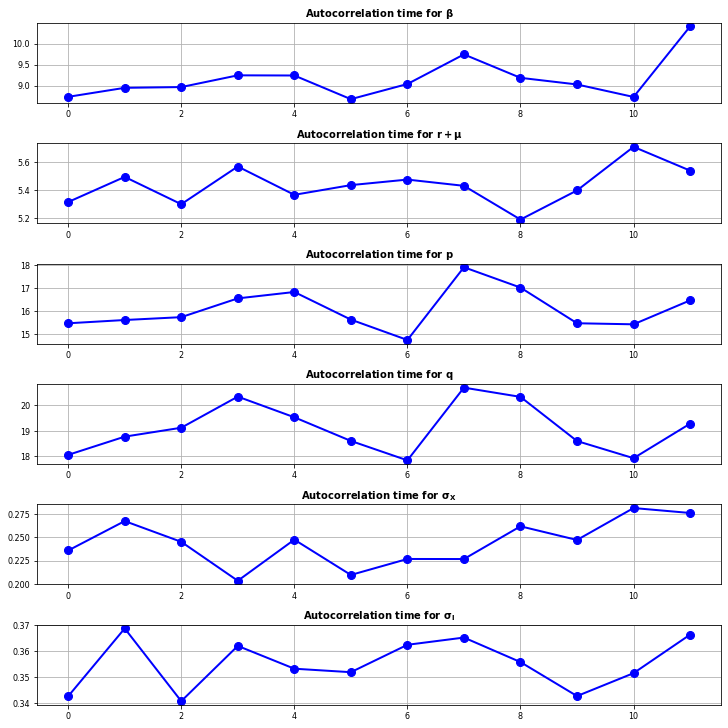

In [79]:
varname = np.array(['beta', 'rmu', 'p', 'q', 'tauX', 'tauI'])
names = np.array([r'$ \mathbf{\beta} $', r'$ \mathbf{r + \mu} $',
                       '$ \mathbf{p} $', '$ \mathbf{q} $', r'$ \mathbf{\sigma_{X}} $',
                       r'$ \mathbf{\sigma_{I}} $'])

times_2 = autocorrelation_time(analysis_esp_2, varname)

autocorrelation_time_plot(times_2, names)

In [199]:
%%time
y = analysis_esp_2.samples['y']
tmax = analysis_esp_2.data['I'].argmax()


times = []
for k in range(y.shape[2]):
    for j in range(y.shape[1]):
        times.append((y[tmax:, j, k] < np.log(1000)).argmax() + tmax)

CPU times: user 1.52 s, sys: 125 ms, total: 1.64 s
Wall time: 1.67 s


In [200]:
print(np.median(tmp), r'$\pm$ ' + f'{np.std(tmp)}')

234.0 $\pm$ 34.794414372303464


Text(0, 0.5, 'Probability of confirmed < 1000')

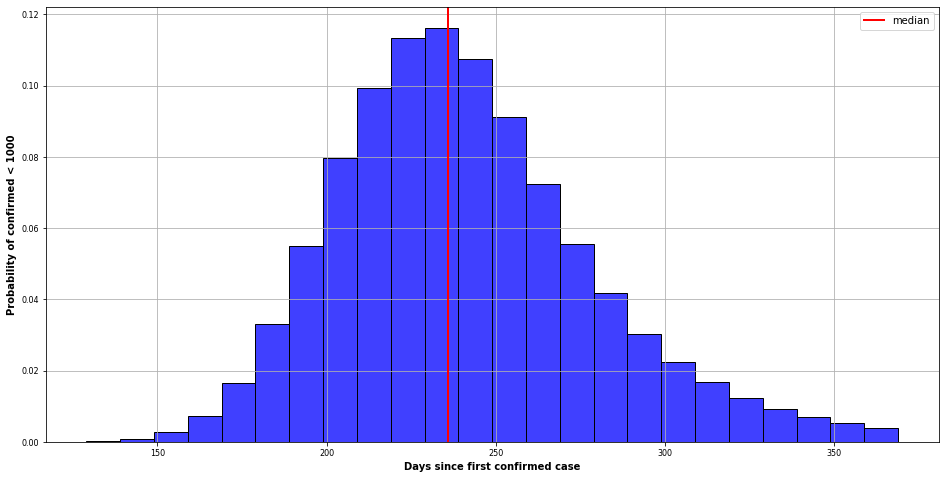

In [206]:
tmp = [time for time in times if time != tmax]

sns.histplot(tmp, binwidth=10, color='b', stat='probability')
plt.gca().axvline(np.median(tmp), c='r', label='median')
plt.grid()
plt.legend()
plt.xlabel('Days since first confirmed case')
plt.ylabel('Probability of confirmed < 1000')

In [9]:
beta = analysis_esp_2.samples['beta'].ravel()
rmu = analysis_esp_2.samples['rmu'].ravel()
p = analysis_esp_2.samples['p'].ravel()
q = analysis_esp_2.samples['q'].ravel()

res = pd.DataFrame(np.column_stack((beta, rmu, p, q)), columns=['beta', 'rmu', 'p', 'q'])
res[res.beta * res.p / (res.rmu * (res.q + res.p)) < 1]

,beta,rmu,p,q
1,0.477144,0.027926,0.003085,0.093346
5,0.468388,0.023295,0.004788,0.096982
6,0.468521,0.025913,0.004724,0.095079
9,0.469285,0.024650,0.002951,0.092470
13,0.470137,0.024596,0.004147,0.096061
...,...,...,...,...
39987,0.465724,0.024219,0.004046,0.094267
39988,0.474165,0.033497,0.005939,0.092317
39992,0.458558,0.020124,0.002170,0.091911
39995,0.464962,0.022280,0.003446,0.094339


In [48]:
beta = np.median(analysis_esp_2.samples['beta'].ravel())
rmu = np.median(analysis_esp_2.samples['rmu'].ravel())
p = np.median(analysis_esp_2.samples['p'].ravel())
q = np.median(analysis_esp_2.samples['q'].ravel())

print(beta * p / (rmu * (q + p)))

beta = np.median(analysis_esp.samples['beta'].ravel())
rmu = np.median(analysis_esp.samples['rmu'].ravel())
p = np.median(analysis_esp.samples['p'].ravel())
q = np.median(analysis_esp.samples['q'].ravel())

print(beta * p / (rmu * (q + p)))

### Trace, posterior distribution, autocorrelation plot after peak (Spain)

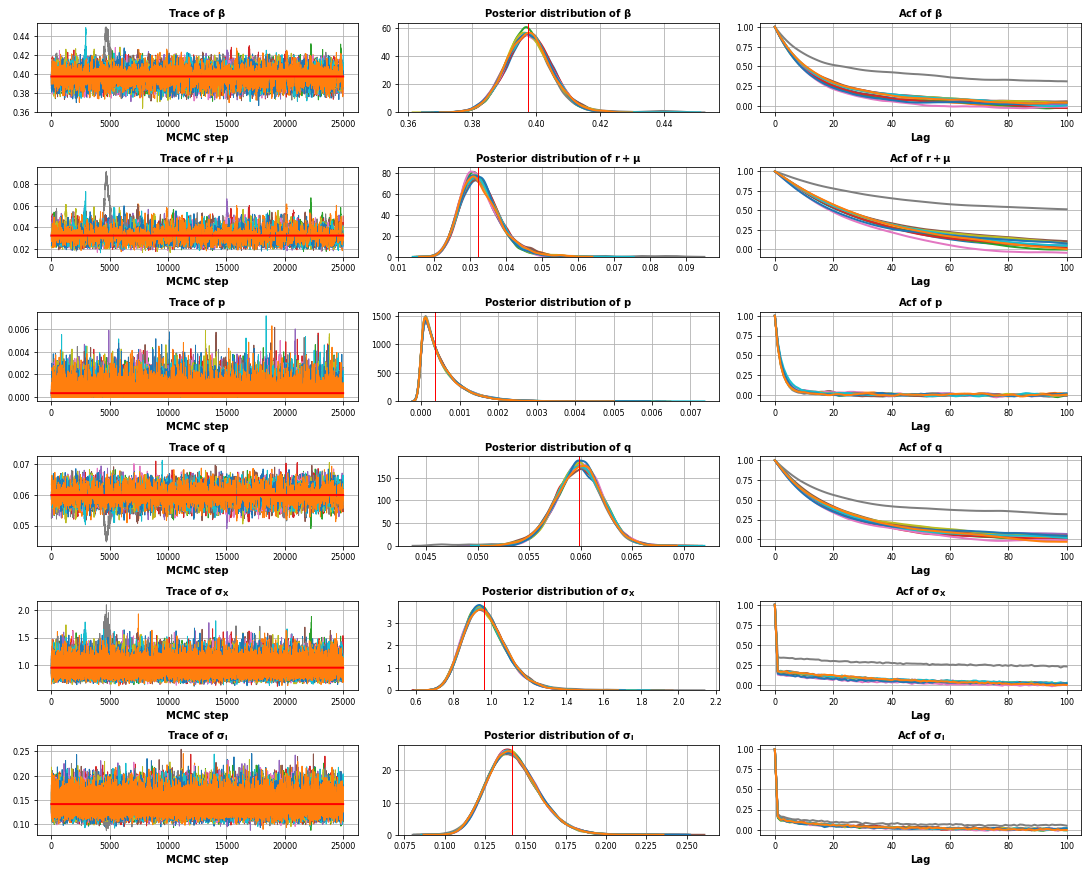

In [84]:
samples_2 = analysis_esp_2.samples
varname = np.array(['beta', 'rmu', 'p', 'q', 'tauX', 'tauI'])
names = np.array([r'$ \mathbf{\beta} $', r'$ \mathbf{r + \mu} $',
                       '$ \mathbf{p} $', '$ \mathbf{q} $', r'$ \mathbf{\sigma_{X}} $',
                       r'$ \mathbf{\sigma_{I}} $'])

fig, ax = plt.subplots(6, 3, figsize=(15, 12), constrained_layout=True)

for i in range(6):
    exp = 1
    if (varname[i] == 'tauI') | (varname[i] == 'tauX'):
        exp = -1/2
    for j in range(12):
        ax[i, 0].plot(np.power(samples_2[varname[i]][0, :, j], exp), label=f'Chain {j+1}', lw=1)
        sns.distplot(np.power(samples_2[varname[i]][0, :, j], exp), hist=False, kde=True, ax=ax[i,1])
        ax[i,2].plot(acf(np.power(samples_2[varname[i]][0, :, j], exp), fft=True, nlags=100))
    ax[i, 0].plot(np.arange(25000), [np.median(np.power(samples_2[varname[i]].ravel(), exp))] * 25000, c='r', lw=2, label='Median')
    ax[i, 0].set_xlabel('MCMC step')
    ax[i, 0].set_title(f'Trace of {names[i]}', weight='bold')
    #ax.legend()#bbox_to_anchor=(1.001, 1.01), loc='upper left')
    ax[i, 0].grid()
    ax[i, 1].axvline(np.median(np.power(samples_2[varname[i]].ravel(), exp)), color='r', lw=1, label='Actual epidemic peak')
    ax[i, 1].set_ylabel('')
    ax[i, 1].set_title(f'Posterior distribution of {names[i]}', weight='bold')
    ax[i, 1].grid()
    ax[i,2].set_xlabel('Lag')
    ax[i,2].set_title(f'Acf of {names[i]}', weight='bold')
    ax[i, 2].grid()

### Plotting fit results after peak

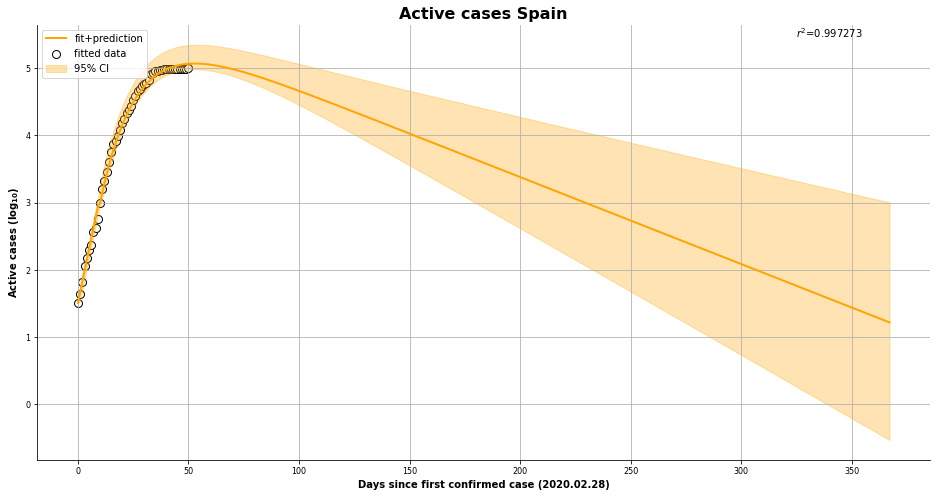

In [88]:
analysis_esp_2.plot_results(Y=True)#, observed=True)
#xmin, xmax = plt.xlim()
#plt.xlim(xmin, 100)

#save data
for var in ['beta', 'rmu', 'q', 'p', 'tauI', 'tauX', 'z', 'y']:
    samples_esp[var].dump("../dataset/Inferenza parametri/samples_esp/samples_%s.npy" %var)

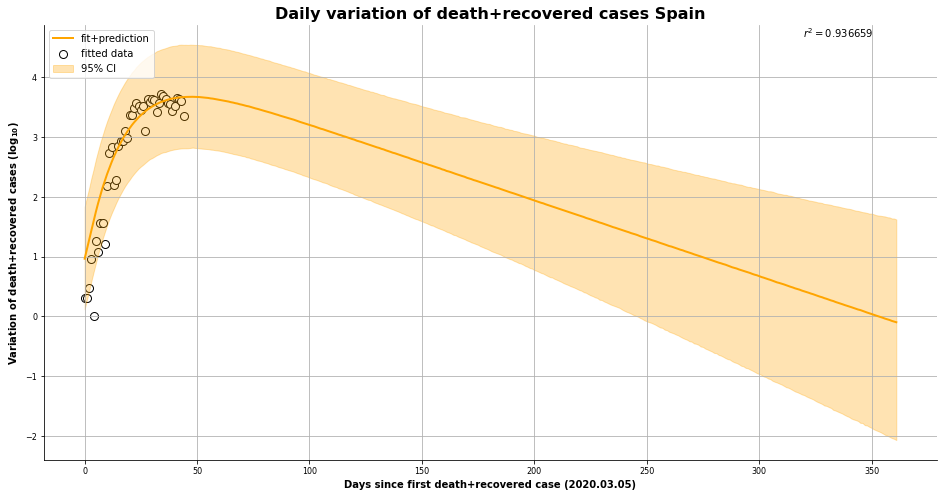

In [91]:
analysis_esp_2.plot_results(Z=True)#, observed=True)
#plt.xlim(0, 100)

## Dataset Italy
The data is taken from Protezione Civile site, starting from 2020.02.24.

In [138]:
# dataset active cases
# all data from 2020-02-28 to today
url_ita = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento" + \
            "-nazionale/dpc-covid19-ita-andamento-nazionale.csv"

df1 = pd.read_csv(url_ita)[['data', 'totale_casi', 'dimessi_guariti', 'deceduti']]
df1.columns = ['Day', 'Confirmed', 'Recovered', 'Death']
df1['Day'] = pd.to_datetime(df1.Day, format='%Y.%m.%d').dt.strftime('%Y.%m.%d')


df1['Confirmed'] = df1.Confirmed - df1.Recovered - df1.Death
df1['Confirmed_smooth'] = df1.Confirmed.rolling(7, min_periods=1).mean()
df1['Recovered_Death'] = (df1.Recovered + df1.Death).diff().fillna(0) # (daily derivative)
df1['Recovered_Death_smooth'] = df1.Recovered_Death.rolling(7, min_periods=1).mean()


#df1 = df1[df1.Day >= '2020.02.01'].reset_index(drop=True)
df1

,Day,Confirmed,Recovered,Death,Confirmed_smooth,Recovered_Death,Recovered_Death_smooth
0,2020.02.24,221,1,7,221.000000,0.0,0.000000
1,2020.02.25,311,1,10,266.000000,3.0,1.500000
2,2020.02.26,385,3,12,305.666667,4.0,2.333333
3,2020.02.27,588,45,17,376.250000,47.0,13.500000
4,2020.02.28,821,46,21,465.200000,5.0,11.800000
...,...,...,...,...,...,...,...
353,2021.02.11,405019,2185655,92729,418839.571429,20229.0,15887.857143
354,2021.02.12,402174,2202077,93045,414990.428571,16738.0,16083.000000
355,2021.02.13,401413,2216050,93356,411330.285714,14284.0,15906.000000
356,2021.02.14,402783,2225519,93577,407867.285714,9690.0,15626.000000


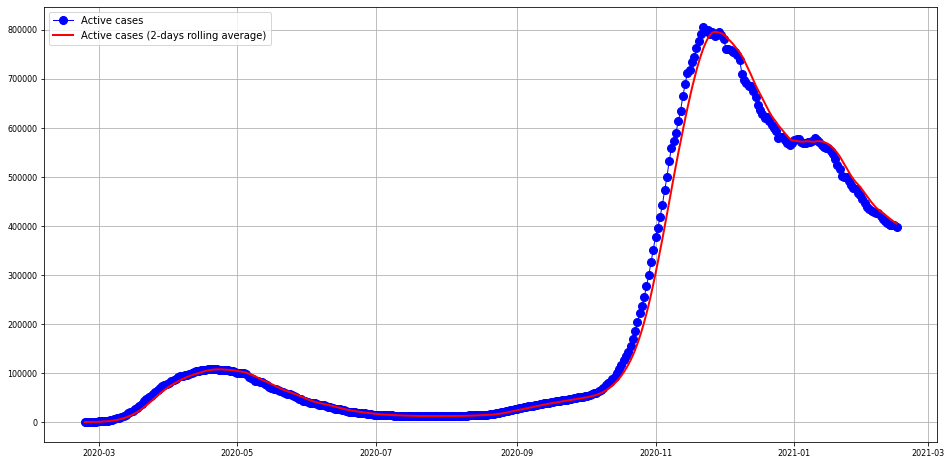

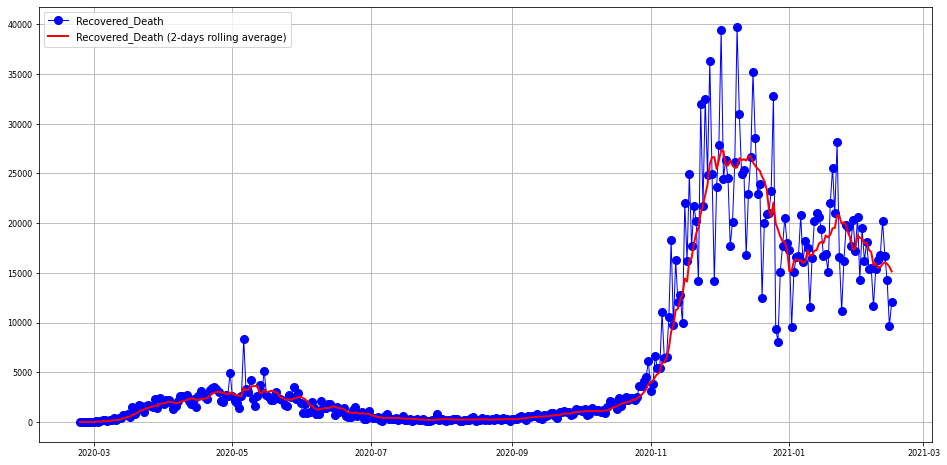

In [139]:
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed, 'bo-', lw=1, label='Active cases')
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed_smooth, 'r', lw=2, label='Active cases (2-days rolling average)')
plt.legend()
plt.grid()
plt.show()

plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death, 'bo-', lw=1, label='Recovered_Death')
plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death_smooth, 'r', lw=2, label='Recovered_Death (2-days rolling average)')
plt.legend()
plt.grid()

In [148]:
#instantiating an analysis object
days = df1['Day']
confirmed = df1['Confirmed_smooth'].values
recovered_death = df1['Recovered_Death_smooth'].values
tq = '2020.03.09' # in teoria sarebbe 9/03
tmax = '2020.03.31' # 2020.03.31
tf = '2020.05.17'
country = 'Italy'

analysis_ita = Analysis(days, confirmed, recovered_death, tq, tmax, tf, country)

# Fit ending before peak data for the daily number of active cases
fit from 2020-02-24 to 2020-03-29 with confinement measure aplied on 2020-03-09

In [151]:
%%time
analysis_ita.sampler(nchains=12, nthreads=12, niter=20000, burn_in=0.5)

sampling: iterations 98672 of 240000, elapsed 0:00:05, remaining 0:00:07
sampling: iterations 240000 of 240000, elapsed 0:00:06, remaining 0:00:00
CPU times: user 51.3 s, sys: 14.7 s, total: 1min 6s
Wall time: 14.8 s


In [152]:
analysis_ita.summary()

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.2416,0.0026,0.2367,0.2469,1.0007
rmu,0.0288,0.0020,0.0252,0.0329,1.0006
q,0.0472,0.0032,0.0432,0.0555,1.0033
p,0.0081,0.0082,0.0004,0.0310,1.0031
tauI,315.9459,79.8754,185.6568,496.6810,1.0003
tauX,6.4191,1.5648,3.8396,9.9672,1.0000


In [7]:
analysis_ita.summary()

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.2988,0.0052,0.2887,0.3091,1.0002
rmu,0.0279,0.0025,0.0234,0.0332,1.0000
q,0.2190,0.5419,0.1501,1.6988,1.0126
p,0.1388,0.5390,0.0670,1.5995,1.0127
tauI,50.8616,13.5921,27.6406,80.9465,1.0066
tauX,3.5800,0.8602,2.1611,5.5181,1.0000


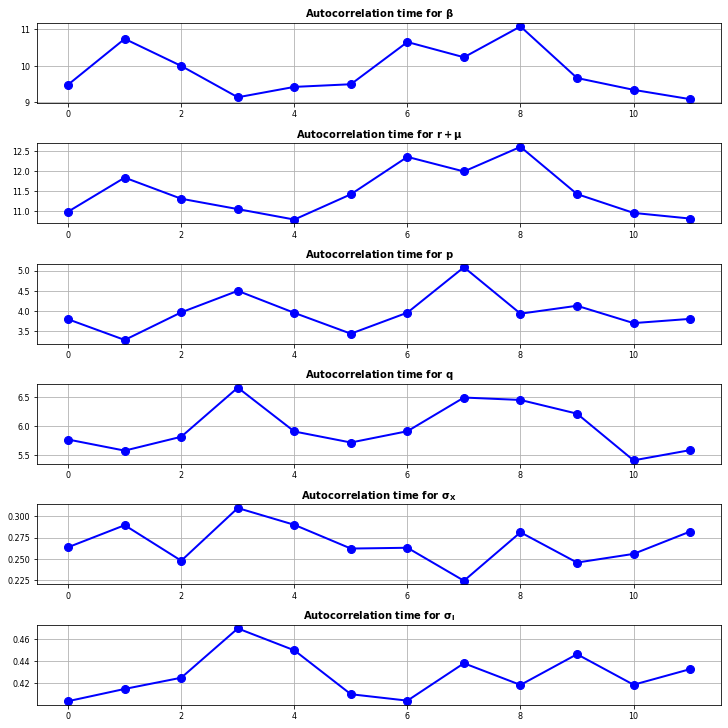

In [97]:
times_ita = autocorrelation_time(analysis_ita, varname)

autocorrelation_time_plot(times_ita, names)

### Trace, posterior distribution, autocorrelation plot before peak (Italy)

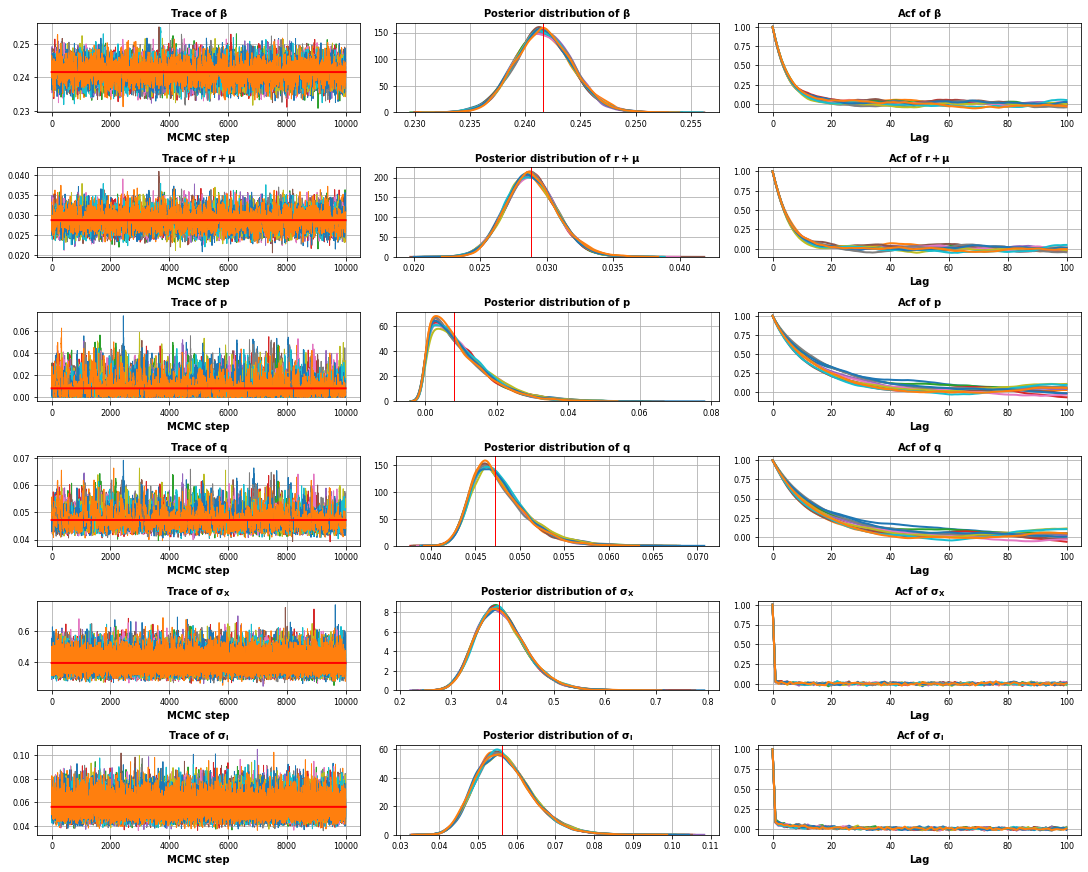

In [153]:
samples_ita = analysis_ita.samples
samples_ita

fig, ax = plt.subplots(6, 3, figsize=(15, 12), constrained_layout=True)

for i in range(6):
    exp = 1
    if (varname[i] == 'tauI') | (varname[i] == 'tauX'):
        exp = -1/2
    for j in range(12):
        ax[i, 0].plot(np.power(samples_ita[varname[i]][0, :, j], exp), label=f'Chain {j+1}', lw=1)
        sns.distplot(np.power(samples_ita[varname[i]][0, :, j], exp), hist=False, kde=True, ax=ax[i,1])
        ax[i,2].plot(acf(np.power(samples_ita[varname[i]][0, :, j], exp), fft=True, nlags=100))
    ax[i, 0].plot(np.arange(10000), [np.median(np.power(samples_ita[varname[i]].ravel(), exp))] * 10000, c='r', lw=2, label='Median')
    ax[i, 0].set_xlabel('MCMC step')
    ax[i, 0].set_title(f'Trace of {names[i]}', weight='bold')
    #ax.legend()#bbox_to_anchor=(1.001, 1.01), loc='upper left')
    ax[i, 0].grid()
    ax[i, 1].axvline(np.median(np.power(samples_ita[varname[i]].ravel(), exp)), color='r', lw=1, label='Actual epidemic peak')
    ax[i, 1].set_ylabel('')
    ax[i, 1].set_title(f'Posterior distribution of {names[i]}', weight='bold')
    ax[i, 1].grid()
    ax[i,2].set_xlabel('Lag')
    ax[i,2].set_title(f'Acf of {names[i]}', weight='bold')
    ax[i, 2].grid()

0.04299359757992665


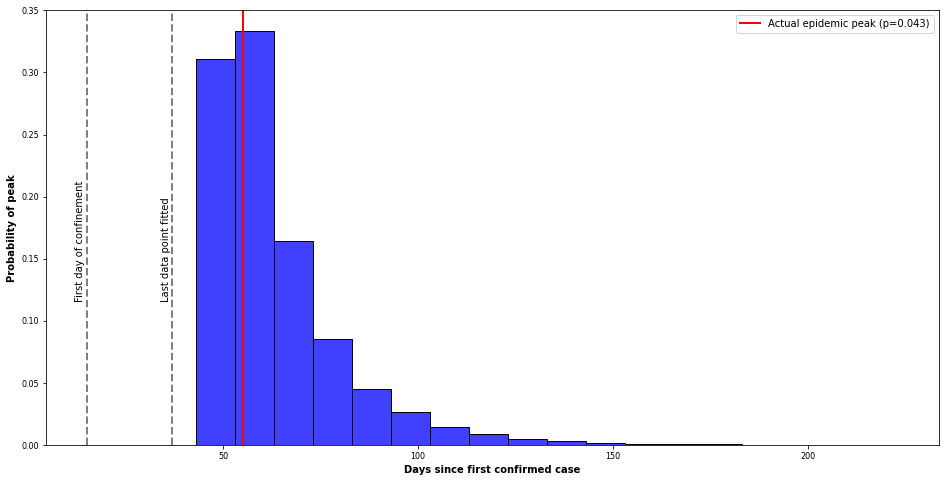

In [338]:
t_peak = peak_posterior(analysis_ita)

### Plotting fit results before peak

### Active cases plot in log scale (Italy)

fit from 2020-03-01 to 2020-03-31 with confinement measure applied on 2020-03-09

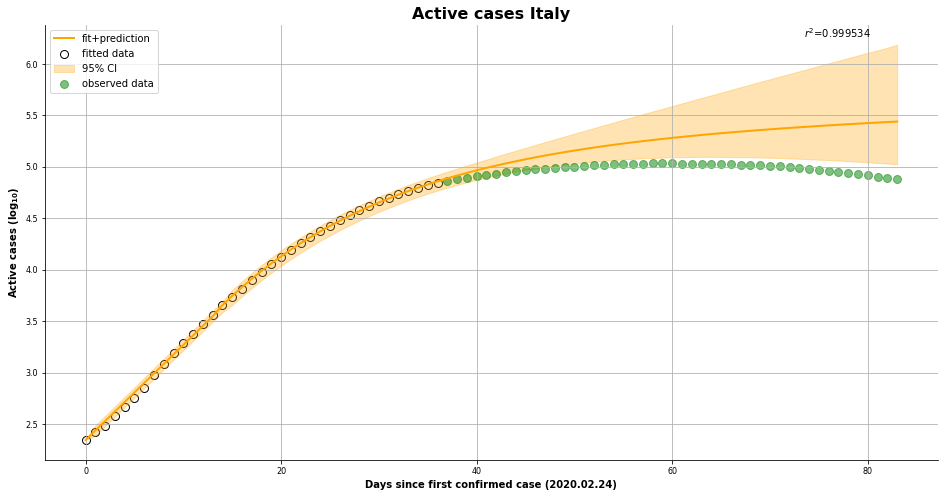

In [170]:
analysis_ita.plot_results(Y=True, observed=True)
#plt.savefig("active_cases_Italy.png", quality=100, transparent=True, dpi=400) 
xmin_I, xmax_I = plt.xlim()
ymin_I, ymax_I = plt.ylim()

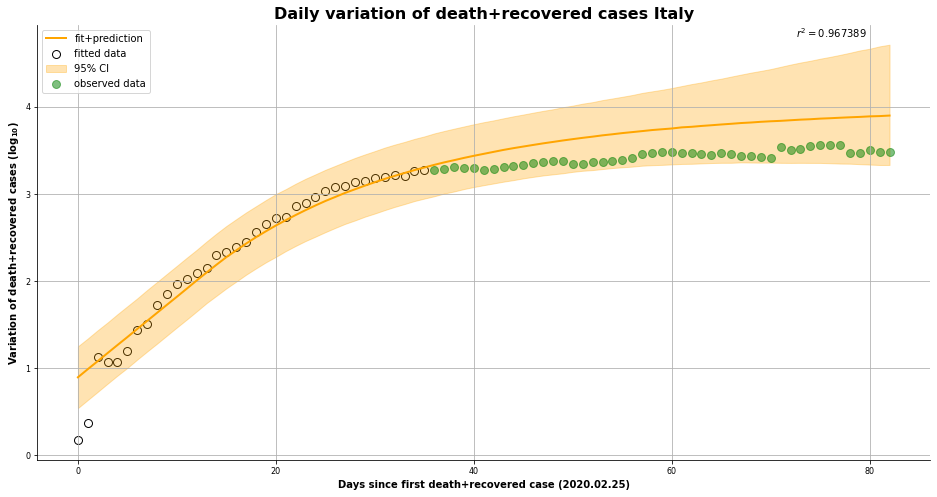

In [169]:
analysis_ita.plot_results(Z=True, observed=True)
#plt.savefig("death_recovered_Italy.png", quality=100, transparent=True, dpi=400)
xmin_X, xmax_X = plt.xlim()
ymin_X, ymax_X = plt.ylim()

# Fit ending after peak data for the daily number of active cases

In [155]:
analysis_ita_2 = Analysis(df1['Day'], df1['Confirmed_smooth'].values, df1['Recovered_Death_smooth'].values, 
                        '2020.03.09', '2020.04.19', '2021.03.01', 'Italy') #2020.05.17

In [160]:
%%time
analysis_ita_2.sampler(nchains=12, nthreads=12, niter=20000, burn_in=0.5)

sampling: iterations 17295 of 240000, elapsed 0:00:05, remaining 0:01:09
sampling: iterations 77382 of 240000, elapsed 0:00:10, remaining 0:00:22
sampling: iterations 134170 of 240000, elapsed 0:00:16, remaining 0:00:12
sampling: iterations 172683 of 240000, elapsed 0:00:21, remaining 0:00:08
sampling: iterations 240000 of 240000, elapsed 0:00:24, remaining 0:00:00
CPU times: user 4min 17s, sys: 31 s, total: 4min 48s
Wall time: 45.4 s


In [161]:
analysis_ita_2.summary()

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.2432,0.0019,0.2395,0.2470,1.0012
rmu,0.0274,0.0013,0.0251,0.0301,1.0019
q,0.0491,0.0008,0.0476,0.0508,1.0014
p,0.0003,0.0004,0.0000,0.0015,1.0004
tauI,321.6642,65.0661,211.4901,466.0645,1.0002
tauX,8.8886,1.7388,5.9105,12.6749,1.0001


In [23]:
analysis_ita_2.summary()

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.2934,0.0045,0.2845,0.3024,1.0001
rmu,0.0259,0.0016,0.0229,0.0292,1.0001
q,0.1129,0.0065,0.1010,0.1266,1.0004
p,0.0220,0.0038,0.0150,0.0298,1.0004
tauI,55.5429,11.0532,36.8122,79.9969,1.0000
tauX,4.8709,0.9409,3.2623,6.9389,1.0000


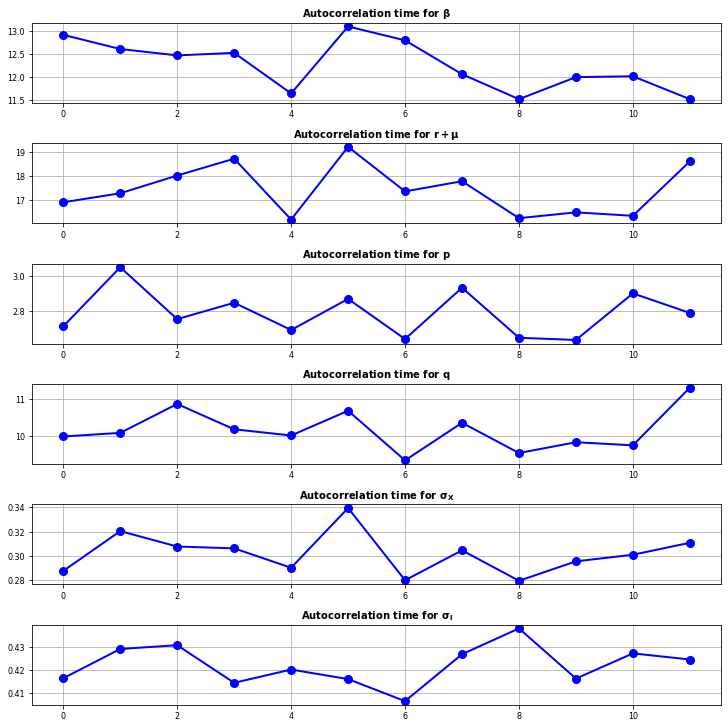

In [58]:
times_ita_2 = autocorrelation_time(analysis_ita_2, varname)

autocorrelation_time_plot(times_ita_2, names)

### Trace, posterior distribution, autocorrelation plot after peak (Italy)

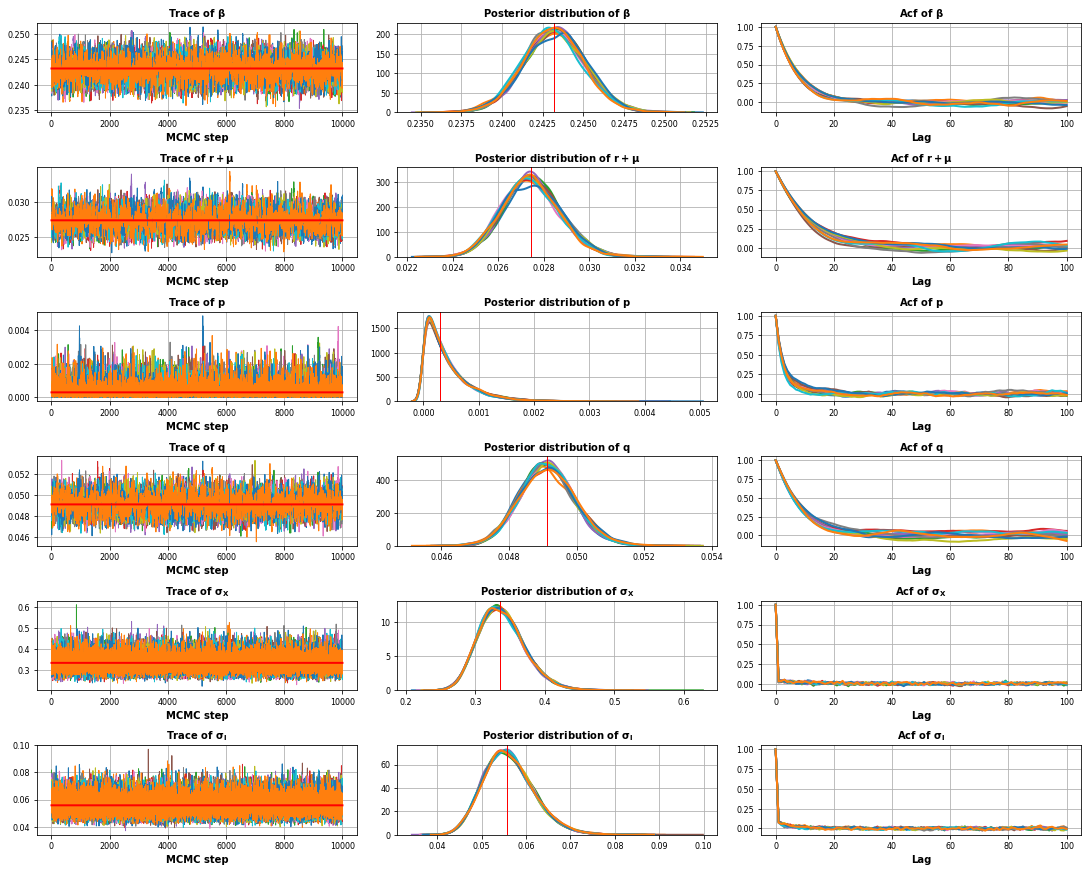

In [163]:
samples_ita_2 = analysis_ita_2.samples
samples_ita_2

fig, ax = plt.subplots(6, 3, figsize=(15, 12), constrained_layout=True)

for i in range(6):
    exp = 1
    if (varname[i] == 'tauI') | (varname[i] == 'tauX'):
        exp = -1/2
    for j in range(12):
        ax[i, 0].plot(np.power(samples_ita_2[varname[i]][0, :, j], exp), label=f'Chain {j+1}', lw=1)
        sns.distplot(np.power(samples_ita_2[varname[i]][0, :, j], exp), hist=False, kde=True, ax=ax[i,1])
        ax[i,2].plot(acf(np.power(samples_ita_2[varname[i]][0, :, j], exp), fft=True, nlags=100))
    ax[i, 0].plot(np.arange(10000), [np.median(np.power(samples_ita_2[varname[i]].ravel(), exp))] * 10000, c='r', lw=2, label='Median')
    ax[i, 0].set_xlabel('MCMC step')
    ax[i, 0].set_title(f'Trace of {names[i]}', weight='bold')
    #ax.legend()#bbox_to_anchor=(1.001, 1.01), loc='upper left')
    ax[i, 0].grid()
    ax[i, 1].axvline(np.median(np.power(samples_ita_2[varname[i]].ravel(), exp)), color='r', lw=1, label='Actual epidemic peak')
    ax[i, 1].set_ylabel('')
    ax[i, 1].set_title(f'Posterior distribution of {names[i]}', weight='bold')
    ax[i, 1].grid()
    ax[i,2].set_xlabel('Lag')
    ax[i,2].set_title(f'Acf of {names[i]}', weight='bold')
    ax[i, 2].grid()

### Plotting fit results after peak

(2.1523625145766485, 5.377017214962806)

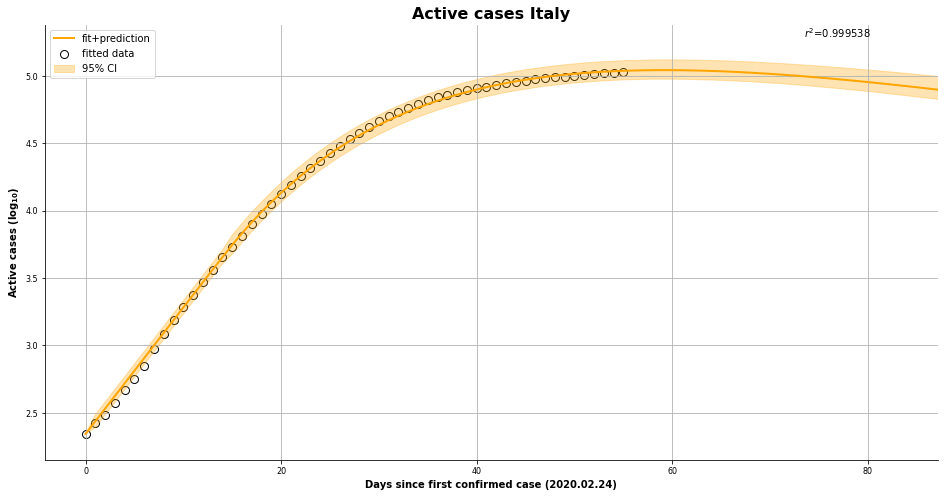

In [180]:
analysis_ita_2.plot_results(Y=True, observed=False)
plt.xlim(xmin_I, xmax_I)
plt.ylim(ymin_I, ymax_I-1)

(-0.05067295987860371, 4.938139856675665)

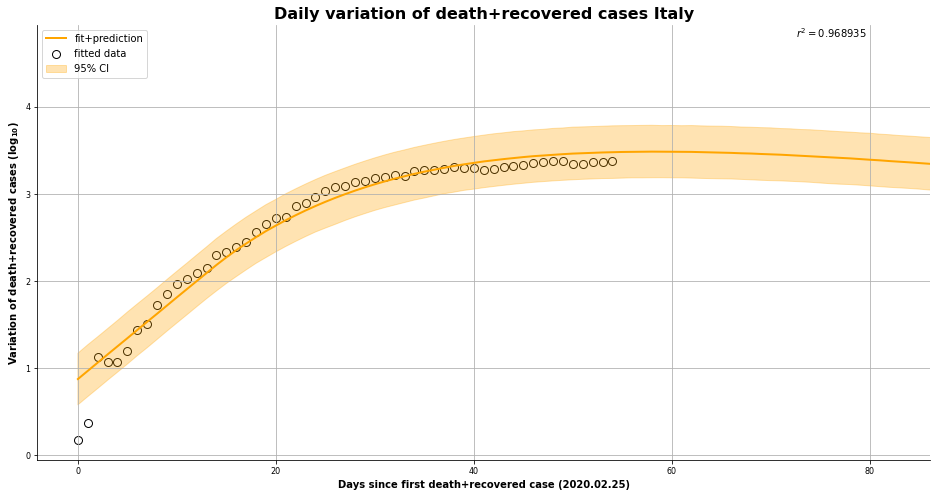

In [174]:
analysis_ita_2.plot_results(Z=True, observed=False)
plt.xlim(xmin_X, xmax_X)
plt.ylim(ymin_X, ymax_X)

In [214]:
%%time
y = analysis_ita_2.samples['y']
tmax = df1[df1.Day == '2020.04.19'].index[0]


times = []
for k in range(y.shape[2]):
    for j in range(y.shape[1]):
        times.append((y[tmax:, j, k] < np.log(1000)).argmax() + tmax)

CPU times: user 594 ms, sys: 31.2 ms, total: 625 ms
Wall time: 591 ms


In [218]:
print(np.median(tmp), f'pm {np.std(tmp)}')

262.0 pm 18.951349607457054


Text(0, 0.5, 'Probability of confirmed < 1000')

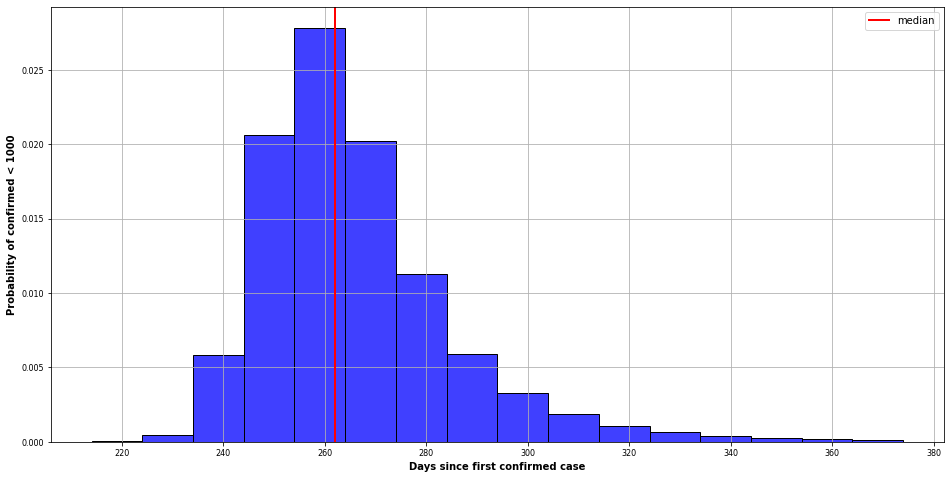

In [216]:
tmp = [time for time in times if time != tmax]

sns.histplot(tmp, binwidth=10, color='b', stat='density')
plt.gca().axvline(np.median(tmp), c='r', label='median')
plt.grid()
plt.legend()
plt.xlabel('Days since first confirmed case')
plt.ylabel('Probability of confirmed < 1000')

# Fit ending second wave (before peak) data for the daily number of active cases

In [235]:
print(df1.Confirmed_smooth.argmax())
df1.loc[df1.Day >= '2020.10.05']

277


,Day,Confirmed,Recovered,Death,Confirmed_smooth,Recovered_Death,Recovered_Death_smooth
224,2020.10.05,58903,232681,36002,54347.857143,783.0,1091.714286
225,2020.10.06,60134,234099,36030,55705.571429,1446.0,1106.857143
226,2020.10.07,62576,235303,36061,57321.714286,1235.0,1109.428571
227,2020.10.08,65952,236363,36083,59222.428571,1082.0,1097.714286
228,2020.10.09,70110,237549,36111,61524.285714,1214.0,1107.000000
...,...,...,...,...,...,...,...
353,2021.02.11,405019,2185655,92729,418839.571429,20229.0,15887.857143
354,2021.02.12,402174,2202077,93045,414990.428571,16738.0,16083.000000
355,2021.02.13,401413,2216050,93356,411330.285714,14284.0,15906.000000
356,2021.02.14,402783,2225519,93577,407867.285714,9690.0,15626.000000


No handles with labels found to put in legend.


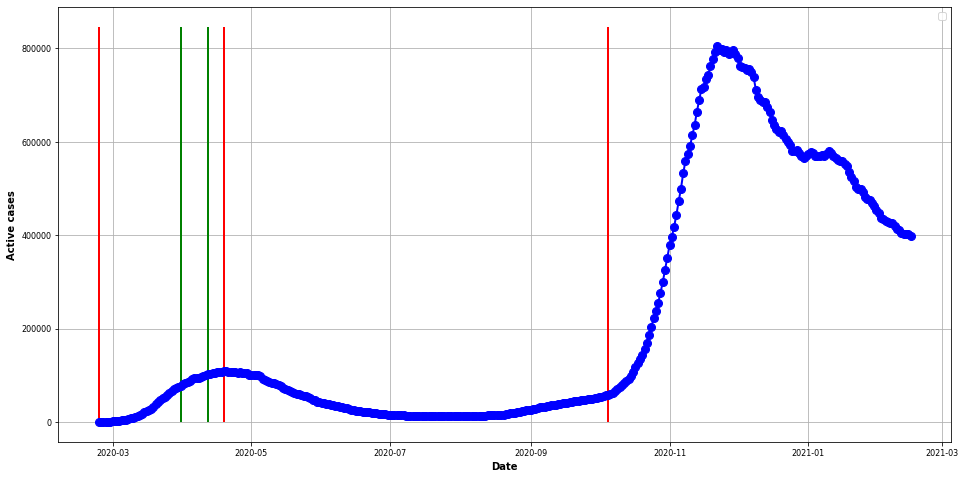

In [253]:
def plot_data(self1, self2, self3, df):
    t01 = self1.data['t0'] - 1
    tmax1 = self1.data['tmax'] - 1
    tmax2 = self2.data['tmax'] - 1
    t03 = self3.data['t0'] - 1
    tmax3 = self3.data['tmax'] - 1
    
    date = pd.to_datetime(df.Day)
    plt.plot(date, df.Confirmed, 'bo-')
    ymin, ymax = plt.ylim()
    plt.vlines(date[t01], 0, ymax, color='r')
    plt.vlines(date[tmax1], 0, ymax, color='g')
    plt.vlines(date[tmax2], 0, ymax, color='r')
    plt.vlines(date[t03], 0, ymax, color='r')
    plt.vlines(date[tmax3], 0, ymax, color='g')
    plt.vlines(date[224], 0, ymax, color='r')
    #plt.vlines(date[258], 0, ymax, color='g')
    #plt.vlines(date[272], 0, ymax, color='r')
    #plt.vlines(date[310], 0, ymax, color='r')
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Active cases')
    plt.legend()
    
plot_data(analysis_ita, analysis_ita_2, analysis_ita_3, df1)

In [309]:
df2 = df1.loc[df1.Day >= '2020.10.12'].reset_index(drop=True)
df2

,Day,Confirmed,Recovered,Death,Confirmed_smooth,Recovered_Death,Recovered_Death_smooth
0,2020.10.12,82764,240600,36205,70777.142857,930.0,1160.285714
1,2020.10.13,87193,242028,36246,74642.714286,1469.0,1163.571429
2,2020.10.14,92445,244065,36289,78909.714286,2080.0,1284.285714
3,2020.10.15,99266,245964,36372,83668.857143,1982.0,1412.857143
4,2020.10.16,107312,247872,36427,88983.428571,1963.0,1519.857143
...,...,...,...,...,...,...,...
122,2021.02.11,405019,2185655,92729,418839.571429,20229.0,15887.857143
123,2021.02.12,402174,2202077,93045,414990.428571,16738.0,16083.000000
124,2021.02.13,401413,2216050,93356,411330.285714,14284.0,15906.000000
125,2021.02.14,402783,2225519,93577,407867.285714,9690.0,15626.000000


In [310]:
analysis_ita_3 = Analysis(df2['Day'],
                          df2['Confirmed_smooth'].values,
                          df2['Recovered_Death_smooth'].values, 
                          '2020.11.06',
                          '2020.11.10', # 2020.11.27
                          '2020.12.31',
                          'Italy') #2020.05.17

In [316]:
%%time
analysis_ita_3.sampler(nchains=12, nthreads=12, niter=50000, burn_in=0.5)

sampling: iterations 263888 of 600000, elapsed 0:00:06, remaining 0:00:08
sampling: iterations 600000 of 600000, elapsed 0:00:08, remaining 0:00:00
CPU times: user 1min 24s, sys: 9.22 s, total: 1min 33s
Wall time: 14.6 s


In [317]:
analysis_ita_3.summary()

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.0856,0.0950,0.0840,0.4231,1.2578
rmu,0.0145,0.0950,0.0138,0.3520,1.2580
q,0.7639,0.7934,0.0513,2.9841,1.1225
p,3.4211,1.2640,0.4974,4.9314,1.0001
tauI,426.6828,119.0017,237.0528,701.1000,1.0000
tauX,61.5249,29.7700,0.0845,104.0925,1.2362


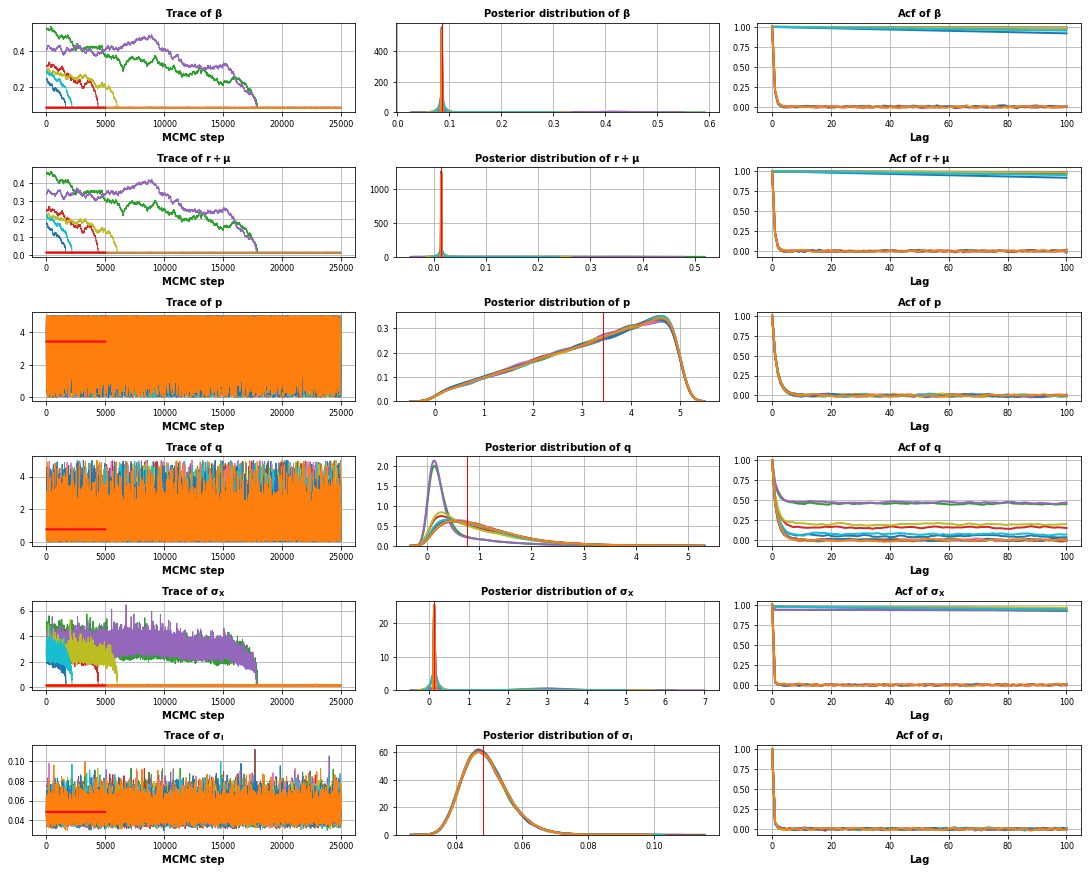

In [318]:
samples_ita_3 = analysis_ita_3.samples
samples_ita_3

fig, ax = plt.subplots(6, 3, figsize=(15, 12), constrained_layout=True)

for i in range(6):
    exp = 1
    if (varname[i] == 'tauI') | (varname[i] == 'tauX'):
        exp = -1/2
    for j in range(12):
        ax[i, 0].plot(np.power(samples_ita_3[varname[i]][0, :, j], exp), label=f'Chain {j+1}', lw=1)
        sns.distplot(np.power(samples_ita_3[varname[i]][0, :, j], exp), hist=False, kde=True, ax=ax[i,1])
        ax[i,2].plot(acf(np.power(samples_ita_3[varname[i]][0, :, j], exp), fft=True, nlags=100))
    ax[i, 0].plot(np.arange(5000), [np.median(np.power(samples_ita_3[varname[i]].ravel(), exp))] * 5000, c='r', lw=2, label='Median')
    ax[i, 0].set_xlabel('MCMC step')
    ax[i, 0].set_title(f'Trace of {names[i]}', weight='bold')
    #ax.legend()#bbox_to_anchor=(1.001, 1.01), loc='upper left')
    ax[i, 0].grid()
    ax[i, 1].axvline(np.median(np.power(samples_ita_3[varname[i]].ravel(), exp)), color='r', lw=1, label='Actual epidemic peak')
    ax[i, 1].set_ylabel('')
    ax[i, 1].set_title(f'Posterior distribution of {names[i]}', weight='bold')
    ax[i, 1].grid()
    ax[i,2].set_xlabel('Lag')
    ax[i,2].set_title(f'Acf of {names[i]}', weight='bold')
    ax[i, 2].grid()

0.0


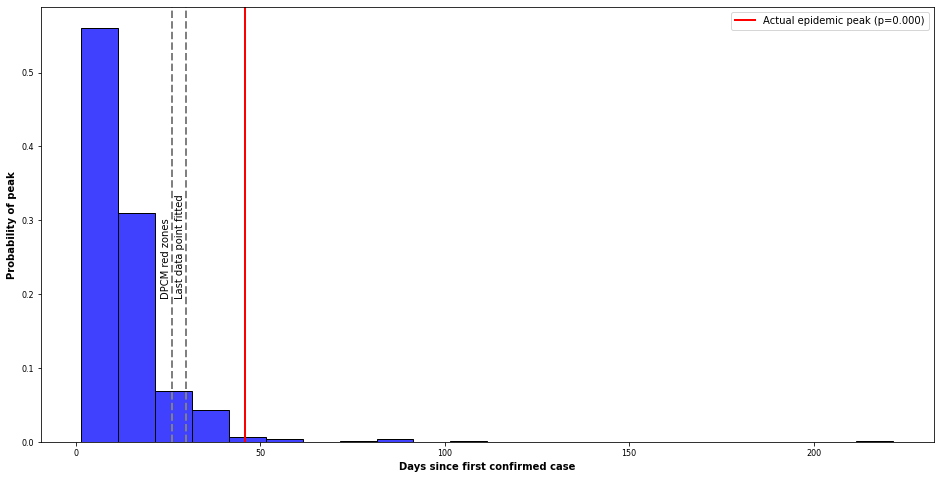

1352       6.135805
1463      13.531910
1535       9.119061
1718       6.290281
1893       6.605941
            ...    
298445     7.681989
298469    27.616906
298517    37.519083
299745    25.792510
299757    14.984220
Length: 608, dtype: float64

In [345]:
peak_posterior(analysis_ita_3, second_wave=True)

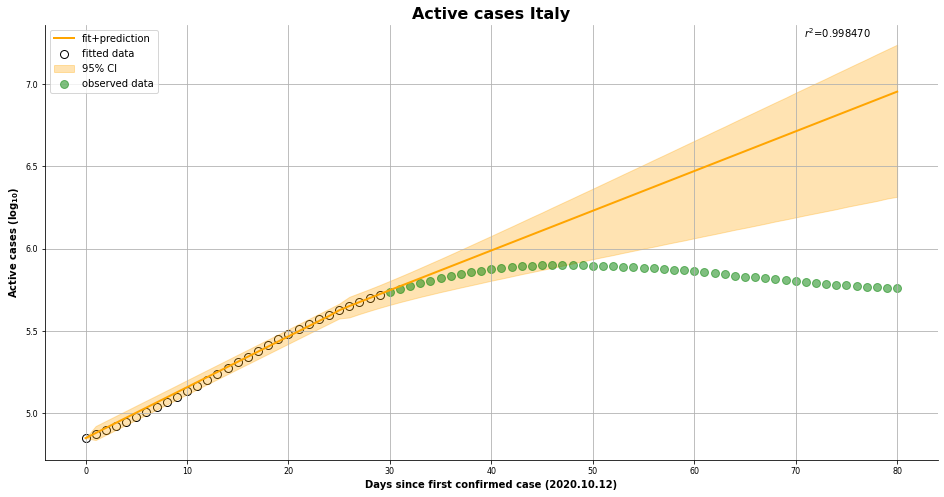

In [319]:
analysis_ita_3.plot_results(Y=True, observed=True)

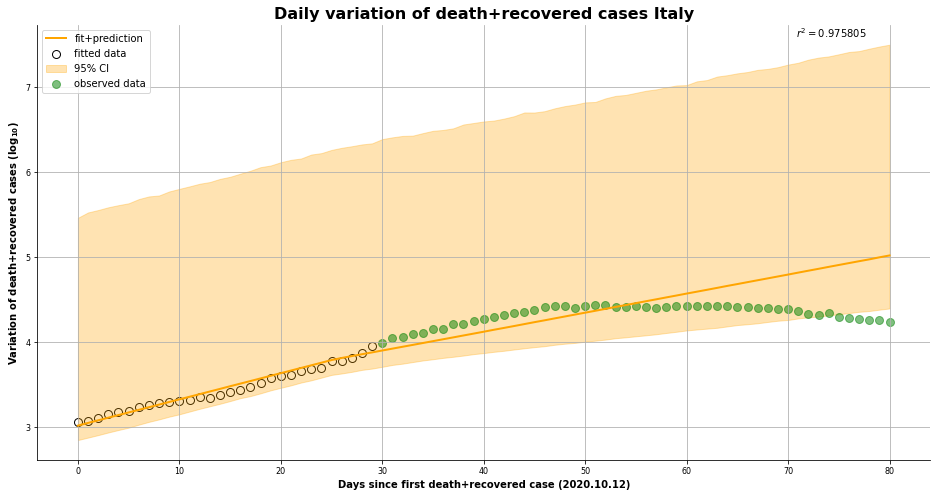

In [320]:
analysis_ita_3.plot_results(Z=True, observed=True)

# References

1. articolo: https://arxiv.org/abs/2004.08842
    1. article [repository](https://github.com/mariocastro73/predictability)
    2. ref [5](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7190554/) 
    
2. sito Ministero della salute Spagnolo: https://www.mscbs.gob.es/
3. JAGS: https://web.sgh.waw.pl/~atoroj/ekonometria_bayesowska/jags_user_manual.pdf
4. pyJAGS: https://github.com/michaelnowotny/pyjags
5. Dati COVID-19 Italia (Protezione Civile): https://github.com/pcm-dpc/COVID-19
6. Data officially reported by Spanish Ministry of Health and curated by DATADISTA: 
<br> https://github.com/datadista/datasets/tree/master/COVID%2019/old_series
7. Updated Datasets (post-peak data), officially reported by Spanish Ministry of Health and curated by El-Pais-Data by late July, 2020:  
https://www.epdata.es/datos/coronavirus-china-datos-graficos/498

8. How to [scrape](https://medium.com/@sateesh.gmc/how-to-scrape-wikipedia-table-using-python-beautiful-soup-cd0d8ee1a319) wikipedia (non usato perché si può fare con la libreria wikipedia, ma da jupyter non sembra funzionare, solo da terminale)
* Da consultare per motivare il doubling time
    * [Plotting1](https://scipython.com/blog/plotting-covid-19-case-growth-charts/) COVID-19 case growth
    * [Plotting2](https://scipython.com/blog/plotting-covid-19-case-growth-charts/) COVID-19 case growth
    [github](https://github.com/xnx/covid-19)
